[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture11_invariance_principle.ipynb)

# Lecture 11: Invariance Principle & Gaussian Analysis

**Topics**: Invariance Principle, Gaussian space, Majority is Stablest

**O'Donnell Chapters**: 10-11  
**Notebook by**: Gabriel Taboada

---

## Key Concepts

| Concept | Description |
|---------|-------------|
| **Invariance Principle** | Boolean functions with low influences behave like Gaussian functions |
| **Multilinear Extension** | The unique multilinear polynomial $\tilde{f}: \mathbb{R}^n \to \mathbb{R}$ agreeing with $f$ on $\{-1,+1\}^n$ |
| **Noise Stability** | $\text{Stab}_\rho[f] = \mathbb{E}[f(x) f(y)]$ where $y$ is $\rho$-correlated with $x$ |
| **Berry-Esseen Bound** | Quantifies how closely the Boolean CDF matches the Gaussian CDF |
| **Majority is Stablest** | Among balanced functions with vanishing influences, Majority maximizes stability |

In [1]:
# Setup
!pip install --upgrade boofun -q

import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis import SpectralAnalyzer
from boofun.analysis.gaussian import (
    GaussianAnalyzer, multilinear_extension, berry_esseen_bound,
)
from boofun.analysis.invariance import InvarianceAnalyzer

np.random.seed(42)
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


## 1. Noise Stability Convergence

The invariance principle predicts that as $n \to \infty$, the noise stability of $\text{Majority}_n$ converges to the **Sheppard limit**:

$$\text{Stab}_\rho[\text{Maj}_n] \to \frac{2}{\pi}\arcsin(\rho)$$

This is exactly the noise stability of the $\text{sgn}$ function on Gaussian space.

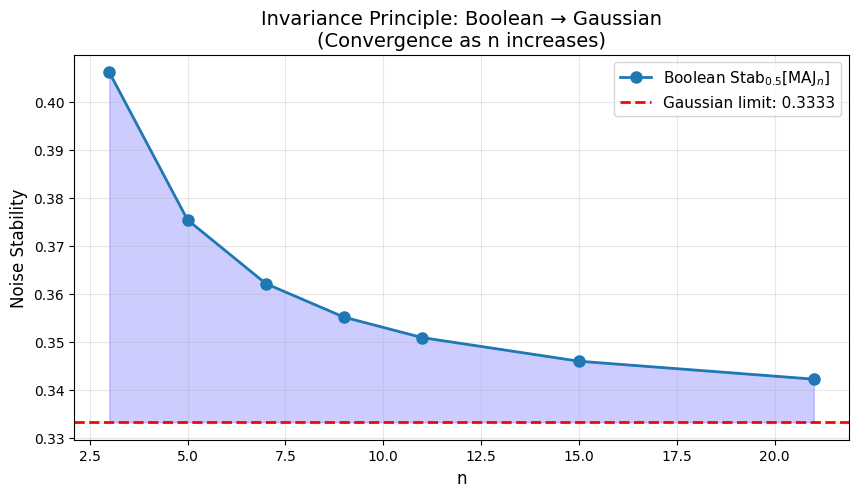

Gaussian limit (Sheppard): (2/π)·arcsin(ρ) = 0.3333
Majority-21 Boolean stability: 0.3423
Gap: 0.0090


In [ ]:
# Noise stability convergence to Gaussian limit
ns = [3, 5, 7, 9, 11, 15, 21]
rho = 0.5

boolean_stab = []
for n in ns:
    maj = bf.majority(n)
    analyzer = SpectralAnalyzer(maj)
    boolean_stab.append(analyzer.noise_stability(rho))

gaussian_limit = (2 / np.pi) * np.arcsin(rho)

plt.figure(figsize=(10, 5))
plt.plot(ns, boolean_stab, 'o-', label=r'Boolean $\text{Stab}_{0.5}[\text{MAJ}_n]$',
         linewidth=2, markersize=8)
plt.axhline(y=gaussian_limit, color='r', linestyle='--',
            label=f'Gaussian limit: {gaussian_limit:.4f}', linewidth=2)
plt.fill_between(ns, boolean_stab, gaussian_limit, alpha=0.2, color='blue')
plt.xlabel('n', fontsize=12)
plt.ylabel('Noise Stability', fontsize=12)
plt.title('Invariance Principle: Boolean \u2192 Gaussian\n(Convergence as n increases)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Gaussian limit (Sheppard): (2/\u03c0)\u00b7arcsin(\u03c1) = {gaussian_limit:.4f}")
print(f"Majority-21 Boolean stability: {boolean_stab[-1]:.4f}")
print(f"Gap: {abs(boolean_stab[-1] - gaussian_limit):.4f}")

## 2. Majority is Stablest

The **Majority is Stablest Theorem** (Mossel-O'Donnell-Oleszkiewicz, 2010): Among balanced functions with vanishing max influence, Majority maximizes noise stability.

This has profound implications for the hardness of MAX-CUT (assuming the Unique Games Conjecture).

In [ ]:
# Majority is Stablest: compare three balanced functions
rho = 0.5
n = 9
gaussian_limit = (2 / np.pi) * np.arcsin(rho)

print("MAJORITY IS STABLEST THEOREM")
print("=" * 55)
print(f"\u03c1 = {rho}, n = {n}")
print(f"Gaussian limit for balanced functions: {gaussian_limit:.4f}")
print()

functions = [
    ("Majority-9", bf.majority(9)),
    ("Parity-9", bf.parity(9)),
    ("Dictator-9", bf.dictator(9, 0)),
]

print("{:<15} {:>10} {:>10} {:>10}".format("Function", "Max Inf", "Stab_\u03c1[f]", "Balanced?"))
print("-" * 50)
for name, f in functions:
    analyzer = SpectralAnalyzer(f)
    stab = analyzer.noise_stability(rho)
    max_inf = max(f.influences())
    is_balanced = "Yes" if abs(analyzer.get_fourier_coefficient(0)) < 0.01 else "No"
    print(f"{name:<15} {max_inf:>10.4f} {stab:>10.4f} {is_balanced:>10}")

print()
print("\u2192 Majority: balanced + low influence \u2192 highest stability")
print("\u2192 Parity: balanced, but Stab_\u03c1 = \u03c1\u207f \u2192 0 (noise destroys it)")
print("\u2192 Dictator: high max influence = 1 (violates low-influence condition)")

MAJORITY IS STABLEST THEOREM
ρ = 0.5, n = 9
Gaussian limit for balanced functions: 0.3333

Function           Max Inf  Stab_ρ[f]  Balanced?
--------------------------------------------------
Majority-9          0.2734     0.3552        Yes
Parity-9            1.0000     0.0020        Yes
Dictator-9          1.0000     0.5000        Yes

→ Majority: balanced + low influence → highest stability
→ Parity: balanced, but Stab_ρ = ρⁿ → 0 (noise destroys it)
→ Dictator: high max influence = 1 (violates low-influence condition)


## 3. Seeing the Invariance Principle: Boolean vs Gaussian Domains

The invariance principle says that for low-influence functions, statistics computed on the Boolean hypercube $\{-1,+1\}^n$ are close to the same statistics computed on Gaussian space $\mathbb{R}^n$.

We can **see** this by evaluating the **multilinear extension** $\tilde{f}(g)$ on Gaussian inputs $g \sim N(0,I_n)$ and comparing to the Boolean distribution of $f(x)$.

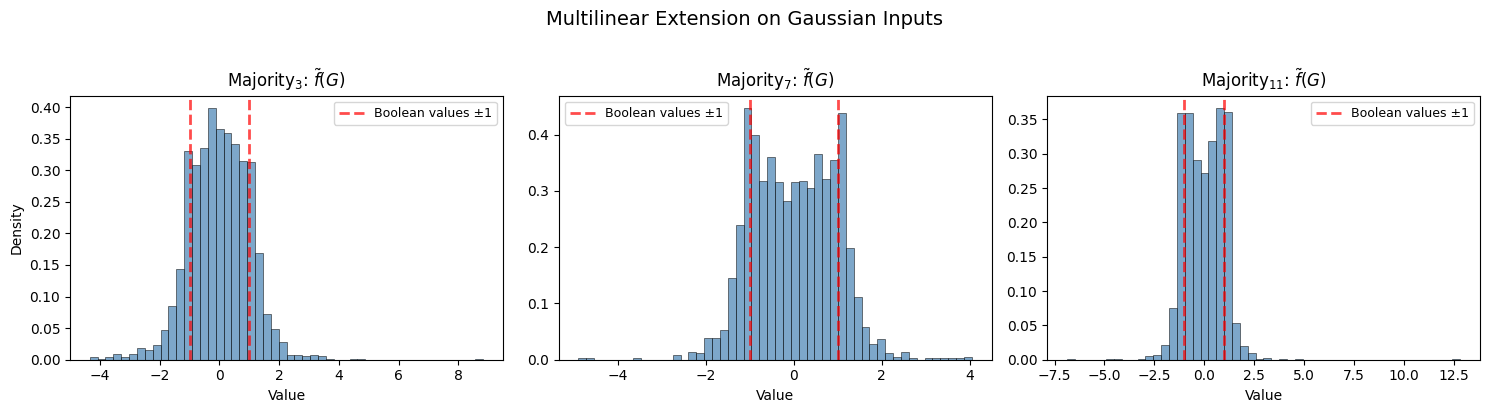

As n grows and influences shrink, the distribution of the multilinear
extension on Gaussians concentrates near ±1 — matching the Boolean domain.
This is the invariance principle made visible.


In [4]:
# Histogram: multilinear extension on Gaussians vs Boolean values
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, n in zip(axes, [3, 7, 11]):
    maj = bf.majority(n)
    p = multilinear_extension(maj)

    # Sample Gaussian vectors and evaluate extension
    np.random.seed(42)
    gaussian_values = [p(np.random.randn(n)) for _ in range(2000)]

    ax.hist(gaussian_values, bins=50, density=True, alpha=0.7,
            color='steelblue', edgecolor='black', linewidth=0.5)
    ax.axvline(x=-1, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7,
               label='Boolean values \u00b11')
    ax.set_title(f'Majority$_{{{n}}}$: $\\tilde{{f}}(G)$', fontsize=12)
    ax.set_xlabel('Value')
    if n == 3:
        ax.set_ylabel('Density')
    ax.legend(fontsize=9)

plt.suptitle('Multilinear Extension on Gaussian Inputs', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("As n grows and influences shrink, the distribution of the multilinear")
print("extension on Gaussians concentrates near \u00b11 \u2014 matching the Boolean domain.")
print("This is the invariance principle made visible.")

In [5]:
# InvarianceAnalyzer.compare_domains(): quantitative comparison
print("Boolean vs Gaussian Domain Comparison:")
print("{:<16} {:>10} {:>13} {:>11} {:>11}".format("Function", "Bool E[f]", "Gauss E[sgn]", "Difference", "Inv. Bound"))
print("-" * 63)

for n in [3, 5, 7, 9, 11]:
    maj = bf.majority(n)
    inv = InvarianceAnalyzer(maj)
    d = inv.compare_domains()
    print(f"Majority-{n:<6d} {d['boolean_mean']:>10.4f} {d['gaussian_sign_mean']:>13.4f}"
          f" {d['mean_difference']:>11.4f} {d['invariance_bound']:>11.4f}")

print()
print("\u2192 As n grows, the difference between Boolean and Gaussian shrinks")
print("\u2192 The invariance bound O(max Inf\u1d62[f]^{1/4}) also shrinks with n")

Boolean vs Gaussian Domain Comparison:
Function          Bool E[f]  Gauss E[sgn]  Difference  Inv. Bound
---------------------------------------------------------------
Majority-3          0.0000       -0.0080      0.0080      0.8409
Majority-5          0.0000        0.0008      0.0008      0.7825


Majority-7          0.0000       -0.0008      0.0008      0.7477


Majority-9          0.0000       -0.0024      0.0024      0.7231


Majority-11         0.0000       -0.0068      0.0068      0.7043

→ As n grows, the difference between Boolean and Gaussian shrinks
→ The invariance bound O(max Infᵢ[f]^{1/4}) also shrinks with n


## 4. Berry-Esseen Bound: Quantifying the Approximation

The **Berry-Esseen theorem** gives an upper bound on the distance between the CDF of a Boolean function's output and the Gaussian CDF. For $f$ with $\text{Var}[f] = 1$:

$$d_{\text{Kolmogorov}}(f, \mathcal{N}) \leq C \cdot \sum_i |\hat{f}(\{i\})|^3 / \text{Var}[f]^{3/2}$$

The bound decreases as influences shrink — confirming that low-influence functions are "approximately Gaussian."

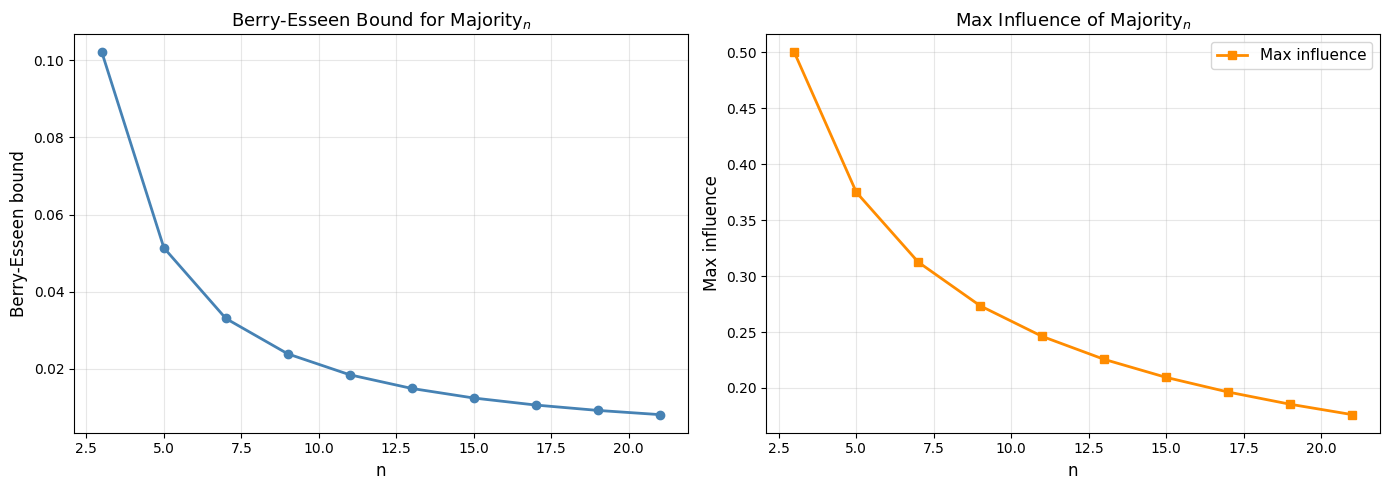

Both curves decrease together: as influences shrink,
the Boolean distribution becomes more Gaussian.
Majority-3: BE bound = 0.1021, max inf = 0.5000
Majority-21: BE bound = 0.0081, max inf = 0.1762


In [6]:
# Berry-Esseen bound convergence
ns = list(range(3, 22, 2))
be_bounds = []
max_infs = []

for n in ns:
    maj = bf.majority(n)
    ga = GaussianAnalyzer(maj)
    be_bounds.append(ga.berry_esseen())
    max_infs.append(max(maj.influences()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(ns, be_bounds, 'o-', linewidth=2, markersize=6, color='steelblue')
ax1.set_xlabel('n', fontsize=12)
ax1.set_ylabel('Berry-Esseen bound', fontsize=12)
ax1.set_title('Berry-Esseen Bound for Majority$_n$', fontsize=13)
ax1.grid(True, alpha=0.3)

ax2.plot(ns, max_infs, 's-', linewidth=2, markersize=6, color='darkorange',
         label='Max influence')
ax2.set_xlabel('n', fontsize=12)
ax2.set_ylabel('Max influence', fontsize=12)
ax2.set_title('Max Influence of Majority$_n$', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("Both curves decrease together: as influences shrink,")
print("the Boolean distribution becomes more Gaussian.")
print(f"Majority-3: BE bound = {be_bounds[0]:.4f}, max inf = {max_infs[0]:.4f}")
print(f"Majority-21: BE bound = {be_bounds[-1]:.4f}, max inf = {max_infs[-1]:.4f}")

## 5. Invariance Distance Across Function Families

The **invariance distance** measures how differently $f$ behaves on Boolean vs Gaussian inputs. Functions with high max influence (Dictator, Parity) have large invariance distance; functions with low max influence (Majority, Tribes) have small invariance distance.

Function            Max Influence  Inv. Distance
------------------------------------------------
Majority-5                 0.3750         0.7825
Majority-9                 0.2734         0.7231
Majority-13                0.2256         0.6892
Tribes(2,3)                0.7500         0.9306
Tribes(3,3)                0.2500         0.7071
Dictator-5                 1.0000         1.0000
Parity-5                   1.0000         1.0000


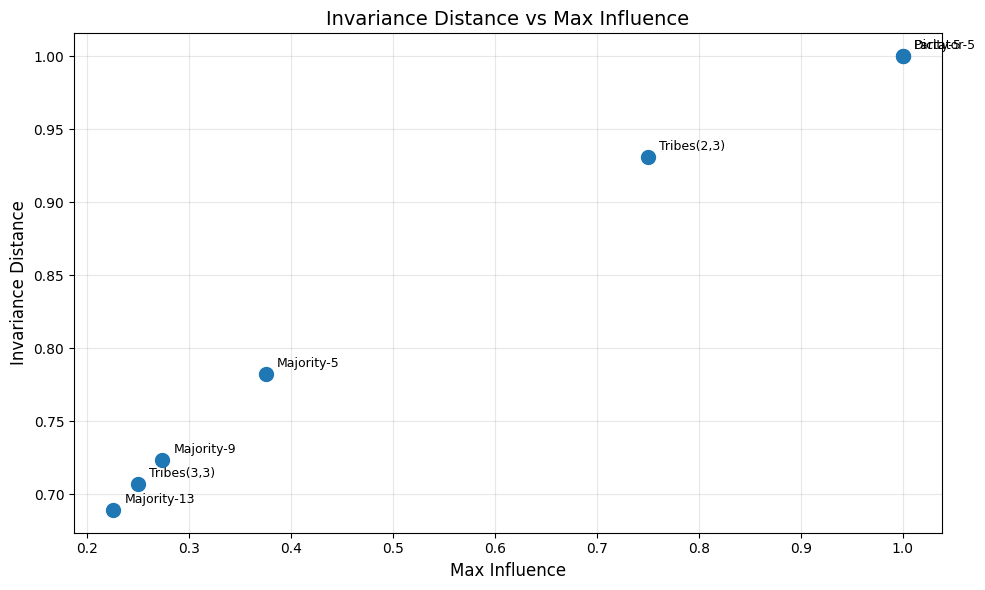

→ Low max influence → small invariance distance → Boolean ≈ Gaussian
→ High max influence (Dictator, Parity) → large distance
→ The invariance principle is a quantitative statement: the bound is O(max Infᵢ^{1/4})


In [7]:
# Invariance distance across function families
test_functions = [
    ("Majority-5", bf.majority(5)),
    ("Majority-9", bf.majority(9)),
    ("Majority-13", bf.majority(13)),
    ("Tribes(2,3)", bf.tribes(2, 3)),
    ("Tribes(3,3)", bf.tribes(3, 3)),
    ("Dictator-5", bf.dictator(5, 0)),
    ("Parity-5", bf.parity(5)),
]

names, max_infs, inv_dists = [], [], []
print("{:<18} {:>14} {:>14}".format("Function", "Max Influence", "Inv. Distance"))
print("-" * 48)
for name, f in test_functions:
    inv = InvarianceAnalyzer(f)
    mi = max(f.influences())
    dist = inv.invariance_bound()
    print(f"{name:<18} {mi:>14.4f} {dist:>14.4f}")
    names.append(name)
    max_infs.append(mi)
    inv_dists.append(dist)

# Scatter plot: max influence vs invariance distance
plt.figure(figsize=(10, 6))
plt.scatter(max_infs, inv_dists, s=100, zorder=5)
for i, name in enumerate(names):
    plt.annotate(name, (max_infs[i], inv_dists[i]),
                 textcoords='offset points', xytext=(8, 5), fontsize=9)
plt.xlabel('Max Influence', fontsize=12)
plt.ylabel('Invariance Distance', fontsize=12)
plt.title('Invariance Distance vs Max Influence', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\u2192 Low max influence \u2192 small invariance distance \u2192 Boolean \u2248 Gaussian")
print("\u2192 High max influence (Dictator, Parity) \u2192 large distance")
print("\u2192 The invariance principle is a quantitative statement: the bound is O(max Inf\u1d62^{1/4})")

## Summary

| Concept | Statement |
|---------|----------|
| **Invariance Principle** | Low-influence Boolean functions behave like Gaussian functions |
| **Sheppard's Formula** | $\text{Stab}_\rho[\text{sgn}] = \frac{2}{\pi} \arcsin(\rho)$ |
| **Majority is Stablest** | Among balanced, low-influence functions, Majority maximizes $\text{Stab}_\rho[f]$ |
| **Berry-Esseen** | Quantifies Boolean $\to$ Gaussian approximation quality |
| **Invariance Distance** | $O(\max_i \text{Inf}_i[f]^{1/4})$ for smooth test functions |
| **Implication** | Hardness of MAX-CUT (assuming Unique Games Conjecture) |

### boofun API

```python
from boofun.analysis import SpectralAnalyzer
from boofun.analysis.gaussian import GaussianAnalyzer, multilinear_extension
from boofun.analysis.invariance import InvarianceAnalyzer

# Noise stability
SpectralAnalyzer(f).noise_stability(rho)

# Gaussian analysis
ga = GaussianAnalyzer(f)
ga.berry_esseen()                    # Berry-Esseen bound
ga.is_approximately_gaussian()       # Quick check
p = multilinear_extension(f)         # p: R^n -> R
p(np.random.randn(n))               # Evaluate on Gaussian input

# Invariance analysis
inv = InvarianceAnalyzer(f)
inv.invariance_bound()               # Invariance distance bound
inv.compare_domains()                # Boolean vs Gaussian stats
inv.noise_stability_deficit(rho)     # Gap from Majority
inv.is_stablest_candidate()          # Check MiS conditions
```

### References

- O'Donnell, *Analysis of Boolean Functions*, Chapters 10-11
- Mossel-O'Donnell-Oleszkiewicz (2010): Majority is Stablest
- Khot-Kindler-Mossel-O'Donnell (2007): UGC-hardness of MAX-CUT